In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, auc
import os
import sys
from tabulate import tabulate
import torch
from torcheval.metrics.functional import multiclass_recall, multiclass_precision, multiclass_accuracy, multiclass_auroc

In [53]:
def calculate_metrics(pred_prob, GT):
    fpr, tpr, thresholds = roc_curve(GT, pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_labels = (pred_prob >= optimal_threshold).astype(int)
    #print("prediction: ", pred_labels)
    #print("GT: ", GT)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    TP = ((pred_labels == 1) & (GT == 1)).sum()
    TN = ((pred_labels == 0) & (GT == 0)).sum()
    FP = ((pred_labels == 1) & (GT == 0)).sum()
    FN = ((pred_labels == 0) & (GT == 1)).sum()
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    auc_score = auc(fpr, tpr)

    results = [
        ["True Positives (TP)", TP],
        ["True Negatives (TN)", TN],
        ["False Positives (FP)", FP],
        ["False Negatives (FN)", FN],
        ["Sensitivity", sensitivity],
        ["Precision", precision],
        ["Specificity", specificity],
        ["AUC", auc_score]
    ]
    # Print results in tabular form
    print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))

    return auc

def calculate_multiclass_metrics(pred_prob, GT):
    #print("prediction: ", pred_labels)
    #print("GT: ", GT)
    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    pred_prob = torch.tensor(pred_prob)
    GT = torch.tensor(GT)
    sensitivity = multiclass_recall(pred_prob, GT, average=None, num_classes=3) 
    precision = multiclass_precision(pred_prob, GT, average=None, num_classes=3)
    specificity = multiclass_accuracy(pred_prob, GT, average=None, num_classes=3)
    auc = multiclass_auroc(pred_prob, GT, num_classes=3)

    results = [
        ["Sensitivity", sensitivity],
        ["Precision", precision],
        ["Specificity", specificity],
        ["AUC", auc]
    ]
    # Print results in tabular form
    print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))

    return auc

### For classification

In [59]:
data = pd.read_csv("/media/andres/T7 Shield1/UCAN_project/Results/classification/CV_6/Metrics/epoch_63.csv")
data = data.drop(columns=(['Unnamed: 0', 'pat_ID', 'prediction_probability (diagnosis)']))
new_order = ['patient_ID', 'scan_date', 'GT', 'prediction', 'prediction_probability C81(diagnosis)', 'prediction_probability C83 (diagnosis)', "prediction_probability Others (diagnosis)"]
data = data[new_order]
data

,patient_ID,scan_date,GT,prediction,prediction_probability C81(diagnosis),prediction_probability C83 (diagnosis),prediction_probability Others (diagnosis)
0,npr561400609660,2015-11-18 00:00:00,2,0,0.561181,0.297588,0.141231
1,npr561400609660,2016-07-22 00:00:00,2,1,0.373775,0.400210,0.226015
2,npr570726077236,2020-10-28 00:00:00,2,1,0.255108,0.390962,0.353930
3,npr575502456942,2013-03-18 00:00:00,1,1,0.368995,0.552953,0.078052
4,npr576907626678,2014-08-05 00:00:00,1,1,0.370442,0.374758,0.254799
...,...,...,...,...,...,...,...
69,npr711322681344,2016-04-19 00:00:00,0,0,0.554760,0.311730,0.133510
70,npr713643843407,2016-08-18 00:00:00,0,0,0.745831,0.127816,0.126353
71,npr720104165515,2020-06-10 00:00:00,0,1,0.163634,0.558559,0.277808
72,npr720104165515,2020-07-30 00:00:00,0,1,0.230958,0.544719,0.224324


In [55]:
from sklearn.metrics import confusion_matrix

data_pred = data[["prediction_probability C81(diagnosis)", "prediction_probability C83 (diagnosis)", "prediction_probability Others (diagnosis)"]]
metric = calculate_multiclass_metrics(np.array(data_pred), np.array(data['GT']))
idx_classes = ["C81_GT", "C83_GT", "Others_GT"]
col_classes = ["C81_Pred", "C83_Pred", "Others_Pred"]
confusion_matrix_df = pd.DataFrame(confusion_matrix(data['GT'], data['prediction']), columns=col_classes, index=idx_classes)
#ax = sns.heatmap(confusion_matrix_df, annot=True)
print(confusion_matrix_df)
print(data.GT.value_counts())

╒═════════════╤══════════════════════════════════╕
│ Metric      │ Value                            │
╞═════════════╪══════════════════════════════════╡
│ Sensitivity │ tensor([0.6452, 0.7273, 0.1429]) │
├─────────────┼──────────────────────────────────┤
│ Precision   │ tensor([0.7143, 0.3810, 0.7500]) │
├─────────────┼──────────────────────────────────┤
│ Specificity │ tensor([0.6452, 0.7273, 0.1429]) │
├─────────────┼──────────────────────────────────┤
│ AUC         │ 0.7898791432380676               │
╘═════════════╧══════════════════════════════════╛
           C81_Pred  C83_Pred  Others_Pred
C81_GT           20        10            1
C83_GT            6        16            0
Others_GT         2        16            3
GT
0    31
1    22
2    21
Name: count, dtype: int64


### Checking cohen's kappa implementation


In [63]:
from sklearn.metrics import cohen_kappa_score

data_pred_converted = np.argmax(data[["prediction_probability C81(diagnosis)", "prediction_probability C83 (diagnosis)", "prediction_probability Others (diagnosis)"]], axis=1)
c_k = cohen_kappa_score(np.array(data_pred_converted), np.array(data['GT']))
c_k

0.28055555555555556

In [46]:
cv_auc_arr = np.load("/media/andres/T7 Shield1/UCAN_project/Results/classification/CV_5/AUC.npy")
for i in range(5):
    temp = np.load("/media/andres/T7 Shield1/UCAN_project/Results/classification/CV_"+str(i)+"/AUC.npy")
    cv_auc_arr = np.column_stack((cv_auc_arr,temp))
print(cv_auc_arr.shape)

(500, 6)


            0         1         2         3         4         5
0    0.610340  0.602984  0.539668  0.594085  0.545281  0.623371
1    0.572531  0.454985  0.551720  0.573159  0.607437  0.638919
2    0.608513  0.485952  0.609332  0.602907  0.596692  0.680068
3    0.666152  0.488765  0.640732  0.619919  0.606166  0.677247
4    0.662963  0.548493  0.637286  0.651925  0.590230  0.685758
..        ...       ...       ...       ...       ...       ...
495  0.665741  0.615738  0.622928  0.637273  0.641414  0.554683
496  0.669753  0.625681  0.610555  0.642946  0.655613  0.647195
497  0.651852  0.664423  0.614342  0.643786  0.617302  0.513833
498  0.640766  0.622435  0.570804  0.646026  0.665793  0.616178
499  0.641847  0.630053  0.518281  0.626485  0.642957  0.549023

[500 rows x 6 columns]


<Axes: >

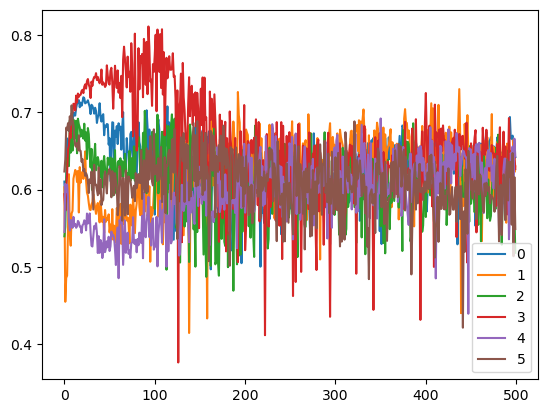

In [47]:
cv_auc_df = pd.DataFrame(cv_auc_arr)
print(cv_auc_df)
cv_auc_df.plot()

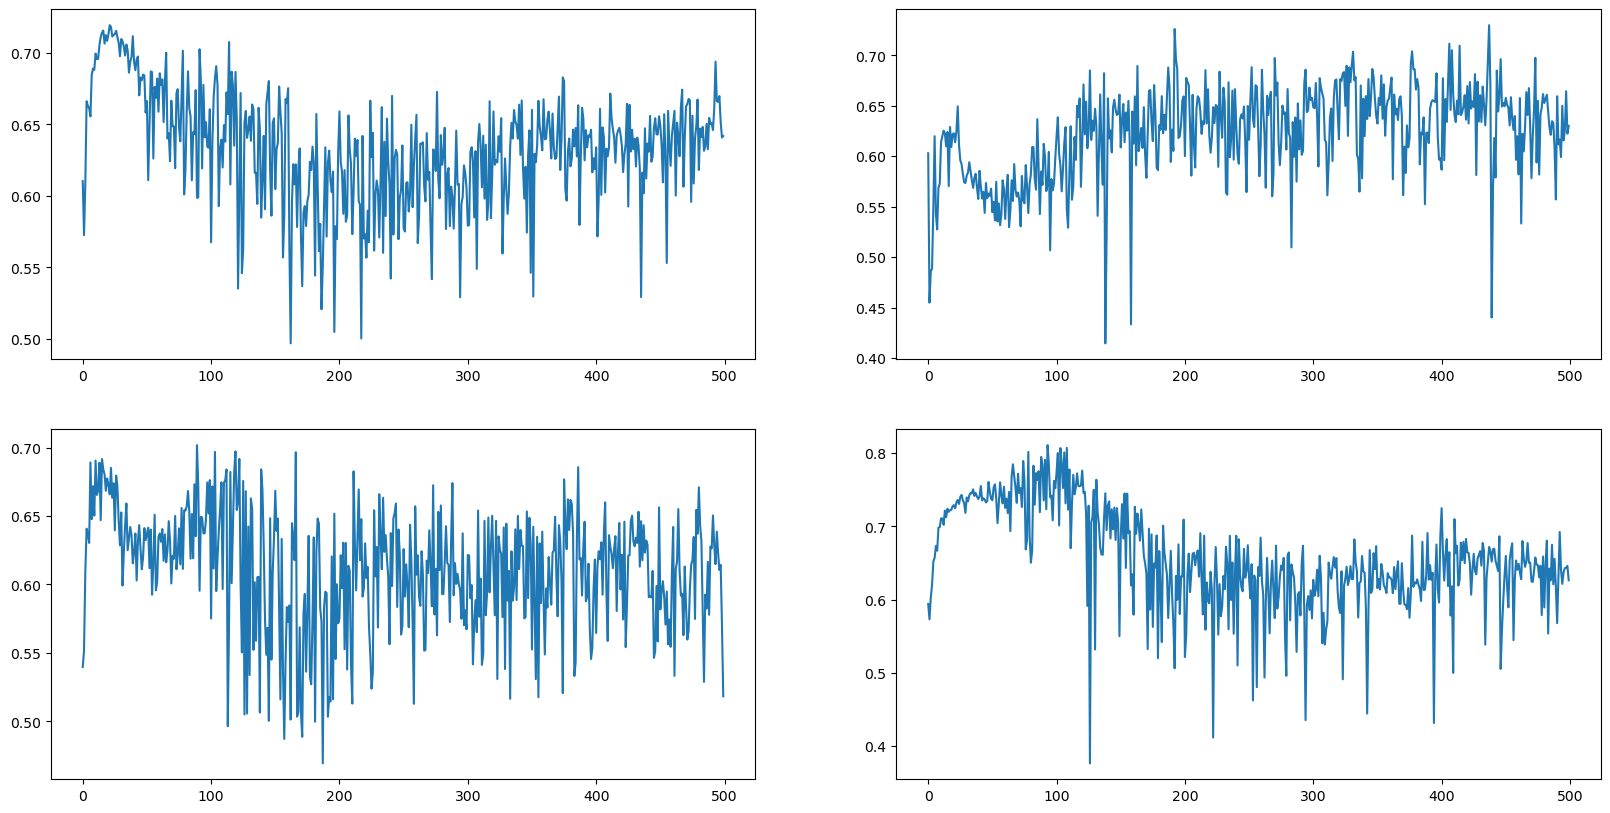

0    0.719316
1    0.729852
2    0.701718
3    0.810803
4    0.691904
5    0.708850
dtype: float32


In [49]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
cv=0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(range(500), cv_auc_df.loc[:,cv].values)
        cv += 1
plt.show()
print(cv_auc_df.max())

### For regression

In [51]:
data = pd.read_csv("/media/andres/T7 Shield1/UCAN_project/Results/regression/Experiment_1/CV_0/Metrics/epoch_847.csv")
data = data.drop(columns=['Unnamed: 0'])
data    

,patient_ID,scan_date,GT,prediction (age)
0,npr102928239238,20101115,54.0,37.433197
1,npr192198005019,20110204,63.0,53.328346
2,npr161070247318,20110307,55.0,50.204414
3,npr113096472044,20110318,58.0,63.756010
4,npr161070247318,20110502,55.0,57.730553
...,...,...,...,...
178,npr175454576662,20220322,57.0,68.445816
179,npr152649782713,20220422,65.0,66.180220
180,npr100825923056,20220510,69.0,73.041430
181,npr110222274795,20220512,72.0,76.134290


In [10]:
metric = mean_absolute_error(np.array(data["GT"]), np.array(data["prediction (age)"]))
metric_r_squared = r2_score(data["GT"], data["prediction (age)"])

In [11]:
print(metric)
print(metric_r_squared)

7.451295360655737
0.46299463012746134


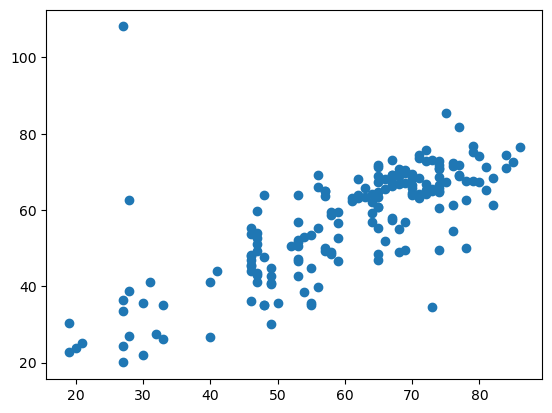

In [9]:
plt.scatter(data['GT'], data["prediction (age)"])

In [9]:
cv_mae_arr = np.load("/home/ashish/Ashish/UCAN/Results/regression/CV_0/MAE.npy")
for i in range(1,10):
    temp = np.load("/home/ashish/Ashish/UCAN/Results/regression/CV_"+str(i)+"/MAE.npy")
    cv_mae_arr = np.column_stack((cv_mae_arr,temp))

In [12]:
cv_mae_arr.shape

(100, 10)

In [16]:
cv_mae_df = pd.DataFrame(cv_mae_arr)
cv_mae_df

,0,1,2,3,4,5,6,7,8,9
0,51.661053,48.158104,51.674908,52.617352,55.328171,51.308605,56.343346,55.107410,54.097870,52.279545
1,43.142235,39.833427,42.676178,44.031742,46.883724,42.839451,47.697330,46.962372,45.799915,43.470936
2,33.354710,31.386930,32.883240,33.960438,36.776108,33.062870,37.441223,36.595123,36.411240,33.704086
3,24.830868,23.659641,24.497389,26.422621,28.304047,24.539446,27.806583,27.303890,27.541706,25.199089
4,17.132412,18.158442,18.267647,20.218649,21.517527,17.344740,18.381001,20.201271,22.732367,19.300184
...,...,...,...,...,...,...,...,...,...,...
95,10.752807,12.237461,11.125750,12.396550,13.261600,39.485367,9.334105,10.946307,11.685050,12.098037
96,10.247961,17.036654,11.745240,10.241927,9.655628,71.689728,9.432148,10.935596,11.764961,13.189807
97,11.452875,16.591263,11.350291,9.978444,15.025595,13.103395,9.445883,12.095978,12.992887,11.825154
98,10.604988,12.258729,17.320435,21.466084,14.135279,12.375731,9.317575,20.422445,13.106354,11.919526


<Axes: >

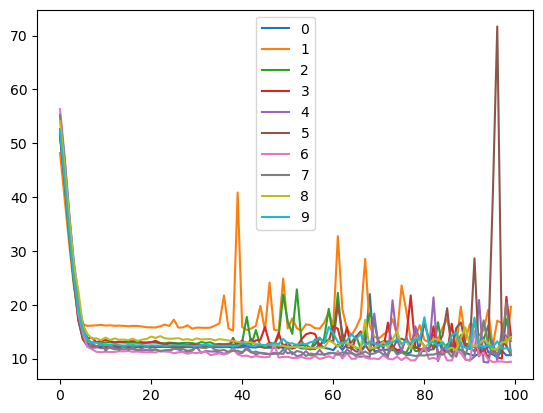

In [17]:
cv_mae_df.plot()

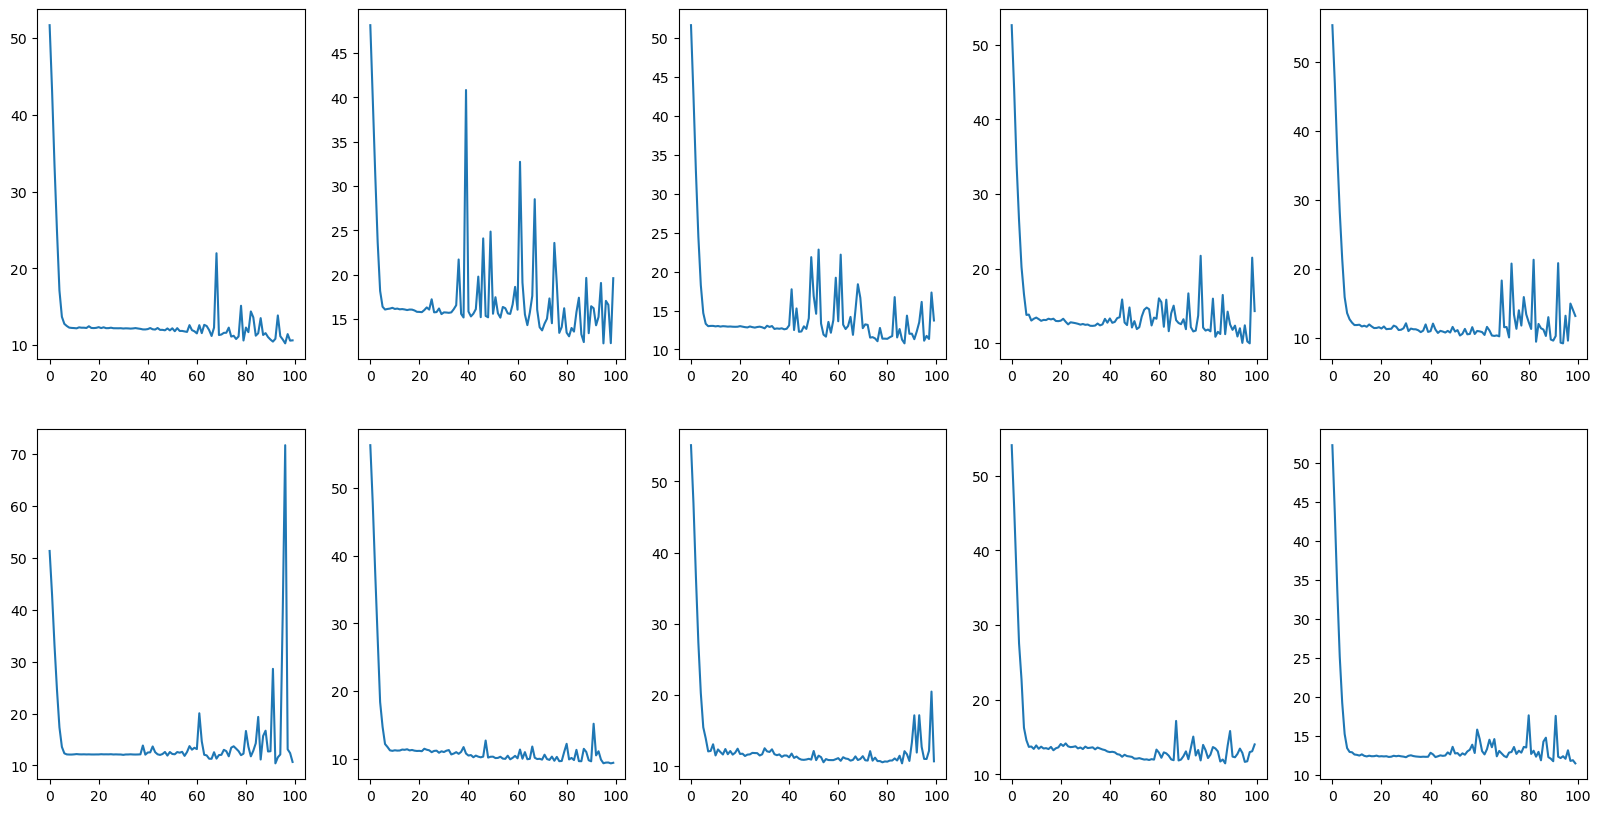

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

cv=0
for i in range(2):
    for j in range(5):
        axs[i, j].plot(range(100), cv_mae_df.loc[:,cv].values)
        cv += 1
plt.show()

In [29]:
df = pd.read_excel("/home/ashish/Ashish/UCAN/dataset_for_training_regression_v2.xlsx")

In [30]:
df.columns

Index(['Unnamed: 0', 'patient_ID', 'scan_date', 'SUV_MIP', 'CT_MIP',
       'SUV_bone', 'CT_bone', 'SUV_lean', 'CT_lean', 'SUV_adipose',
       'CT_adipose', 'SUV_air', 'CT_air', 'patient_age',
       'incorrect_projection'],
      dtype='object')

<Axes: >

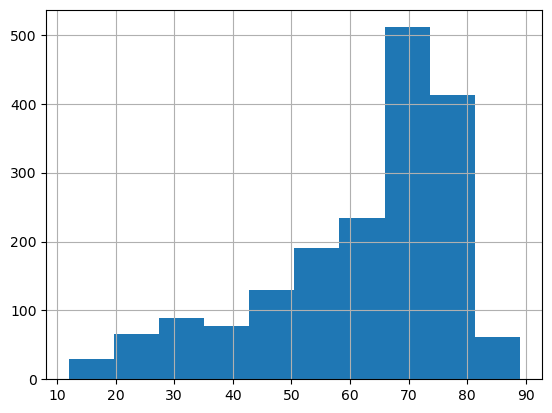

In [31]:
df['patient_age'].hist()

### Check reshaped projections

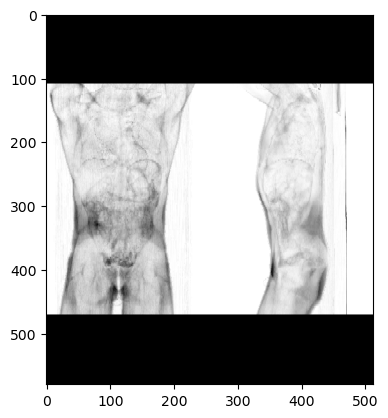

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
image = np.load("/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/lpr385705046400/20140313/CT_adipose.npy")
plt.imshow(image, cmap="gray")
plt.show()

In [10]:
path = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/"
lst1 = ["SUV_", "CT_"]
lst2 = ["MIP.npy","bone.npy","lean.npy","adipose.npy","air.npy"]

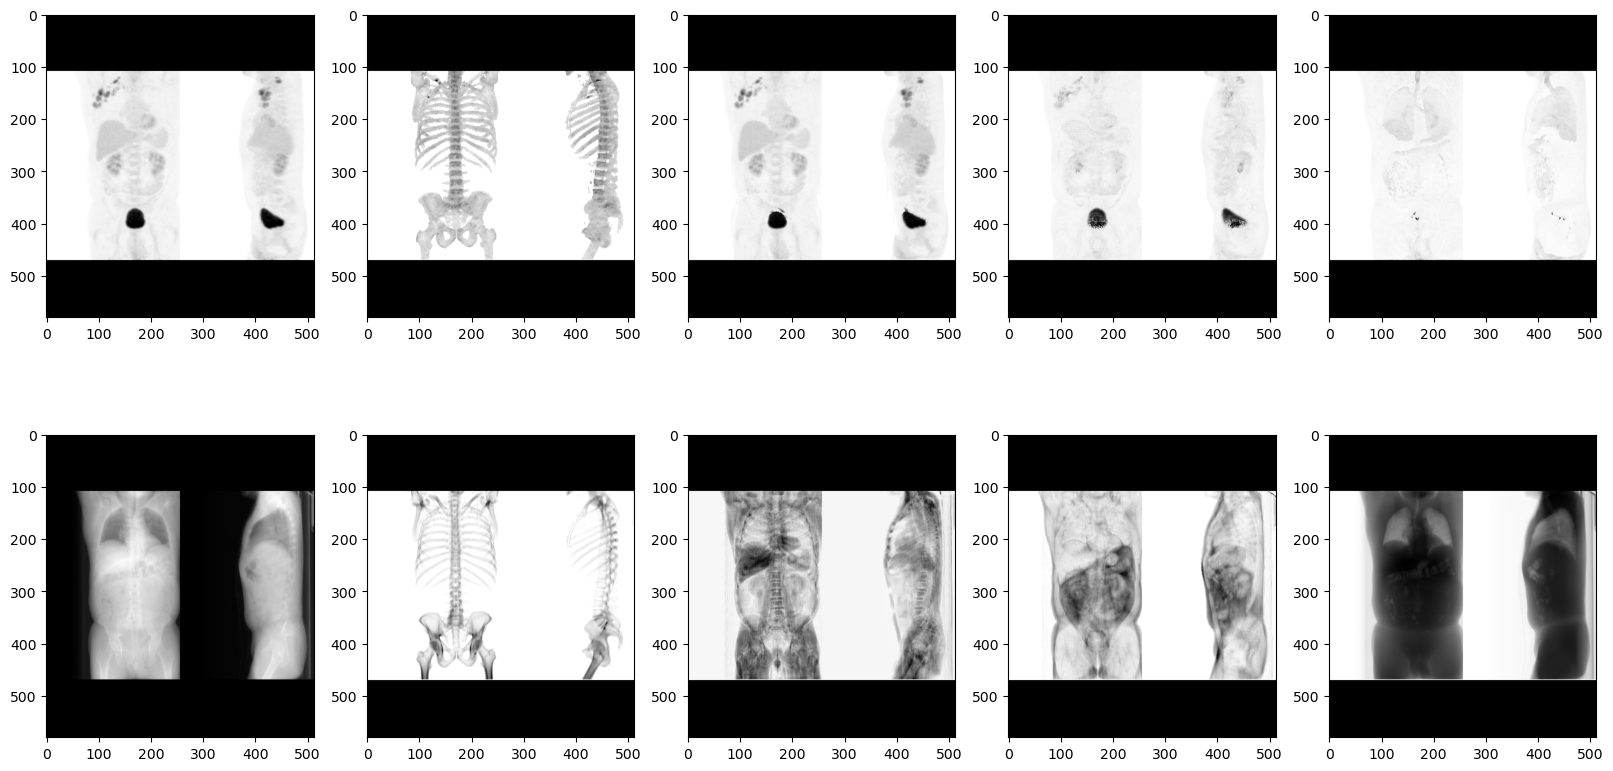

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

cv=0
for i in range(2):
    for j in range(5):
        img = np.load(path + lst1[i] + lst2[j])
        axs[i, j].imshow(img,cmap="gray")
        cv += 1
plt.show()

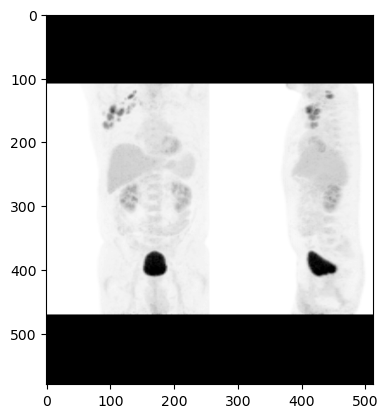

In [12]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_MIP.npy"
image_max = np.load(img)
plt.imshow(image_max, cmap="gray")
plt.show()

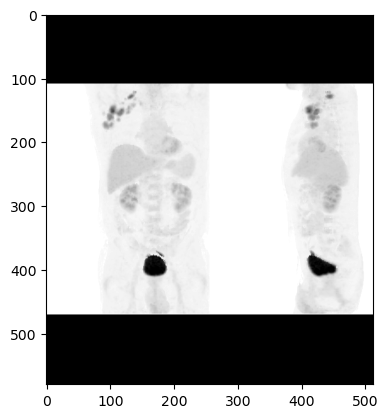

In [13]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_lean.npy"
image_mean = np.load(img)
plt.imshow(image_mean, cmap="gray")
plt.show()

In [14]:
(image_max == image_mean).all()

False